<font size=4> Добрый день, Ольга! Меня зовут Алан, будем обмениваться с тобой опытом для успешного прохождения задания! Если не против, предлагаю общаться на ты (иначе дай знать, и перейдем на «вы»). Свои рекомендации буду оформлять в виде комментариев в Markdown ячейках:<br><strong>
    <li> <font color='red'> «❌ красный цвет» </font> – важно исправить или внести пояснения
    <li> <font color='orange'> «⚠️желтый цвет» </font>  – учесть, но можно не исправлять 
    <li> <font color='green'> «✔️ зеленый цвет» </font> – все отлично, плюс альтернативные пути решения задачи
    <li>   <font color='steelblue'>«синий цвет» </font> - просто текст комментария
     </strong>
<br> В скобках буду указывать версию комментария. Прошу при внесении правок мои комментарии не удалять, а свои писать в соседних ячейках и выделять удобным цветом. Так коммуникация будет проходить эффективнее 👍.<br>
</font>

# Выбор локации для скважины

<div style="background: black; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color=white><u><b>ДЕДЛАЙН</b></u></font>
</div>

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
# Чтобы не забыть, какая библиотека для чего:

# основная Pandas
import pandas as pd
# NumPy
import numpy as np
# графики и диаграммы
import matplotlib.pyplot as plt
# деление выборки
from sklearn.model_selection import train_test_split
# линейная регрессия
from sklearn.linear_model import LinearRegression
# метрика MSE
from sklearn.metrics import mean_squared_error
# статистика
from scipy import stats as st

Поскольку у нас данные по трём различным регионам, загружаем каждый в отдельную переменную.

In [2]:
# открытие файла - локальное или на платформе
try:
    data0 = pd.read_csv('geo_data_0.csv')
    data1 = pd.read_csv('geo_data_1.csv')
    data2 = pd.read_csv('geo_data_2.csv')
except:
    data0 = pd.read_csv('/datasets/geo_data_0.csv')
    data1 = pd.read_csv('/datasets/geo_data_1.csv')
    data2 = pd.read_csv('/datasets/geo_data_2.csv')

<div class='alert alert-success'> ✔️Хорошо, что сгруппировала импорты в одной месте для облегчения читабельности кода. try/except тоже к месту для возможности запуска с сервера и локально.
</div>

In [3]:
data0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [4]:
data0.info()
# были проверены и два остальных набора, но вывод оставлен только для одного

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Столбцы в датасетах (каждый набор соответствует отдельному региону):
* id — уникальный идентификатор скважины;
* f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
* product — объём запасов в скважине (тыс. баррелей).

Перед нами задача регрессии, т.к. нужно предсказывать не категорию, а количество (целевой признак - `product`). Пропусков в данных нет, проверим на дубликаты и посмотрим значения целевого столбца.

In [5]:
data0['id'].duplicated().sum()

10

In [6]:
data1['id'].duplicated().sum()

4

In [7]:
data2['id'].duplicated().sum()

4

<div class='alert alert-success'> ✔️Молодец, что нашла дубли по id
</div>

In [8]:
data0['product'].unique()

array([105.28006184,  73.03775027,  85.26564713, ...,  64.37544259,
        74.04076435, 149.63324561])

In [9]:
data1['product'].unique()

array([  3.17910258,  26.95326103, 134.76630516, 137.94540774,
        84.03888568, 110.99214671,  53.90652206,   0.        ,
       107.81304413,  57.08562465,  30.13236361,  80.85978309])

In [10]:
data2['product'].unique()

array([ 27.75867323,  56.06969663,  62.87191005, ..., 157.08007975,
        51.79525299, 102.77576749])

Пропусков нет, но обнаружены явные дубликаты (по столбцу ID) во всех трёх датасетах. От них надо будет избавиться, как и от столбца `id` (который не нужен для расчётов и только засорит выборку). Также обнаружено странное распределение значений столбца `product` в регионе 1, нужно проверить графически.

In [11]:
def oil_hist(data, bins, xlim, ylim):
    plt.figure(figsize=[12,8])
    plt.hist(data, bins=bins)
    plt.xlim([0, xlim])
    plt.ylim([0, ylim])
    plt.xlabel("Объем нефти на скважину, тыс. баррелей")
    plt.ylabel("Количество скважин")
    plt.title("Гистограмма распределения по объёму скважин")
    plt.show()

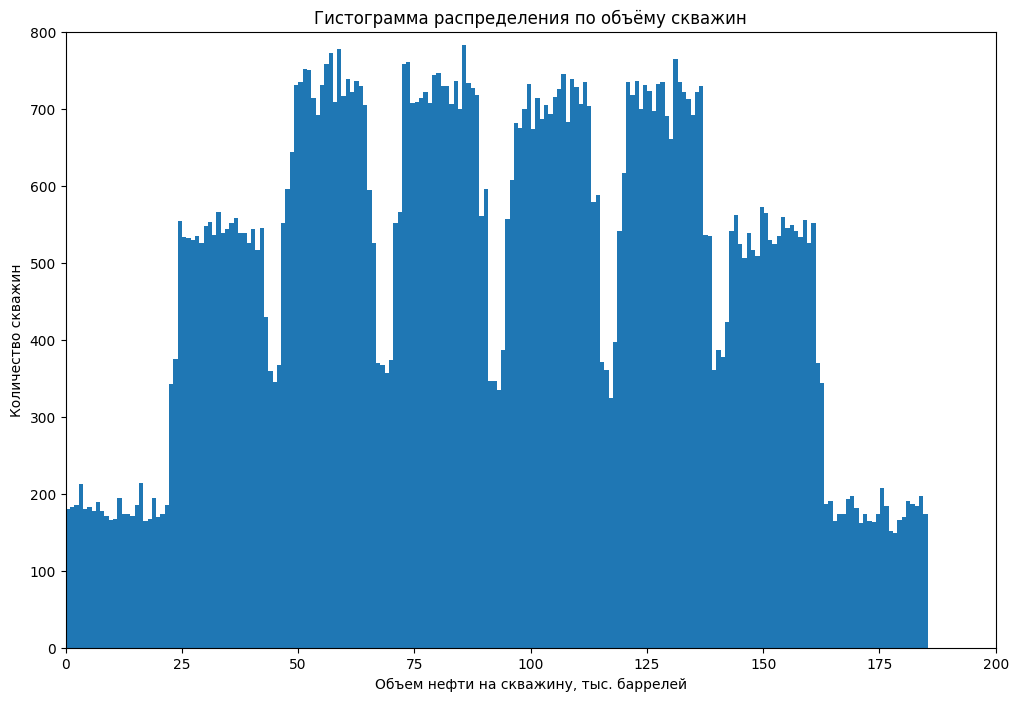

In [12]:
oil_hist(data0['product'], 200, 200, 800)

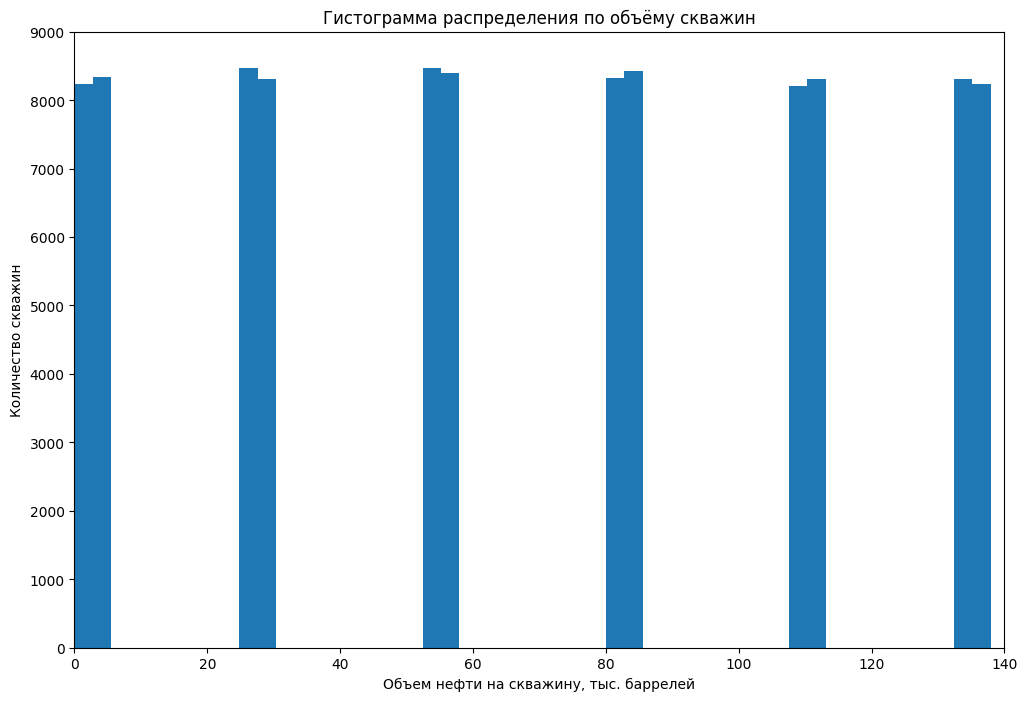

In [13]:
oil_hist(data1['product'], 50, 140, 9000)

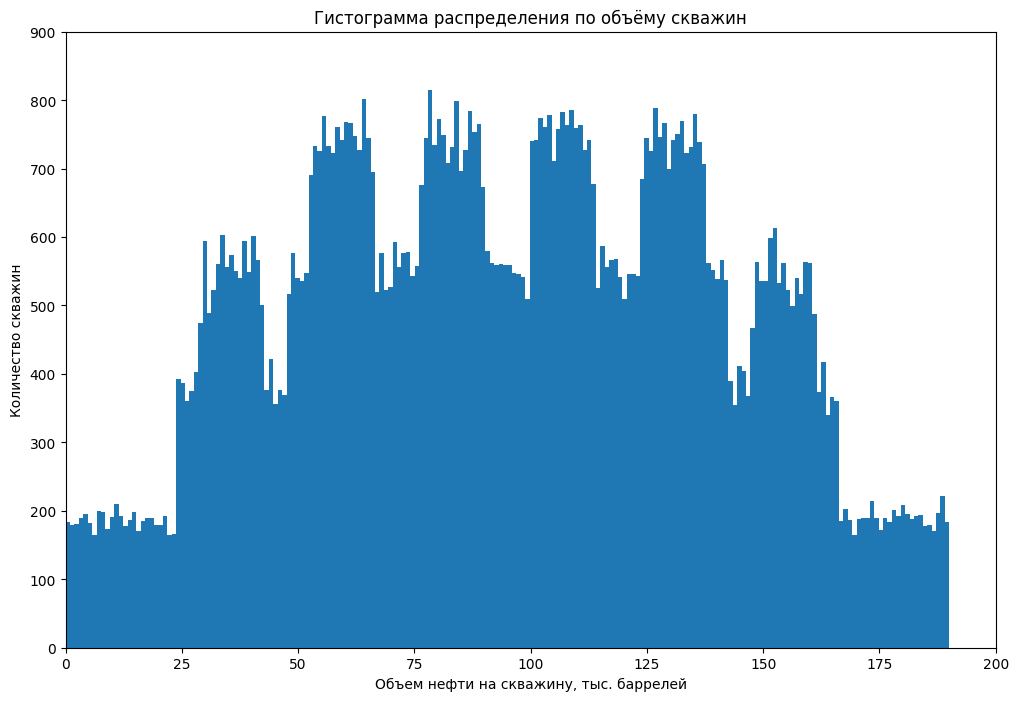

In [14]:
oil_hist(data2['product'], 200, 200, 900)

Все регионы имеют выраженный "паттерн" распределения ресурса скважин - они распределены с шагом, чередуя больший ресурс с меньшим. Наиболее сильно это выражено в регионе 1, в то время как в регионах 0 и 2 это распределение имеет некоторые признаки нормального - большинство скважин находятся в середине распределения, а крайние значения встречаются редко. 

**Гипотеза**: в регионе 1 были заполнены нулями пропуски (этим объясняется большое по сравнению с остальными количество нулевых значений). Посчитаем число нулей по каждому региону.

<div class='alert alert-success'> ✔️Молодец, что заметил особенности распределения цели в регионе 1, еще может это вызвано разрешительной способностью измерительного оборудования, реакцией только на некоторые пороги.
</div>

In [15]:
def check_zeros(data, name):
    zeros = data[data[name] == 0][name].count()
    percent = (zeros / data.shape[0]) * 100
    print('Количество нулевых значений:', zeros)
    print('Процент нулевых значений: {:.3f}'.format(percent))

In [16]:
regions = [data0, data1, data2]

for region in regions:
    check_zeros(region, 'product')

Количество нулевых значений: 1
Процент нулевых значений: 0.001
Количество нулевых значений: 8235
Процент нулевых значений: 8.235
Количество нулевых значений: 1
Процент нулевых значений: 0.001


Нулей в регионах 0 и 2 всего по одному, в регионе 1 же - 8235, что составляет 8,235% от всех значений. Это выглядит как подтверждение гипотезы о заполненных пропусках, но из условия задачи мне непонятно, можно ли удалить такие значения. Поэтому я удаляю только явные дубликаты (определяя их по столбцу `id`) и избавляюсь от него как от ненужного в расчётах. Строка с удалением нулевых значений закомментирована на случай, если она понадобится.

In [17]:
def drop_data(data):
    data_cleaned = data.drop_duplicates(subset='id')
    data_cleaned = data_cleaned.drop('id', axis=1)
    # data_cleaned = data_cleaned.loc[data_cleaned['product'] != 0]
    features = data_cleaned.drop('product', axis=1)
    target = data_cleaned['product']
    return features, target

In [18]:
def split_features(features, target):
    features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345, stratify=pd.qcut(target, 10))
    print(features_train.shape)
    print(features_valid.shape)
    print(target_train.shape)
    print(target_valid.shape)
    return features_train, features_valid, target_train, target_valid

## Обучение и проверка модели

Разбиваем выборки для каждого региона на обучающую и валидационную выборки в соотношении 75%-25%.

In [19]:
features0, target0 = drop_data(data0)
features0_train, features0_valid, target0_train, target0_valid = split_features(features0, target0)
features1, target1 = drop_data(data1)
features1_train, features1_valid, target1_train, target1_valid = split_features(features1, target1)
features2, target2 = drop_data(data2)
features2_train, features2_valid, target2_train, target2_valid = split_features(features2, target2)

(74992, 3)
(24998, 3)
(74992,)
(24998,)
(74997, 3)
(24999, 3)
(74997,)
(24999,)
(74997, 3)
(24999, 3)
(74997,)
(24999,)


<div class='alert alert-success'> ✔️Корректное разделение на 2 выборки, молодец, что выводишь размеры выборок, чтобы убедиться в правильности. 
</div>

In [20]:
def model_work(name, model, features_train, target_train, features_valid, target_valid):
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    mse = mean_squared_error(target_valid, predicted_valid)
    print(name)
    # решила везде форматировать вывод для избежания слишком длинных чисел
    print('Среднее значение: {:.2f}'.format(predicted_valid.mean()))
    print('RMSE: {:.2f}'.format(mse ** 0.5))
    print()
    return predicted_valid

In [21]:
model = LinearRegression()
predicted0_valid = model_work('Регион 0', model, features0_train, target0_train, features0_valid, target0_valid)
predicted1_valid = model_work('Регион 1', model, features1_train, target1_train, features1_valid, target1_valid)
predicted2_valid = model_work('Регион 2', model, features2_train, target2_train, features2_valid, target2_valid)

Регион 0
Среднее значение: 92.54
RMSE: 37.76

Регион 1
Среднее значение: 68.84
RMSE: 0.89

Регион 2
Среднее значение: 95.00
RMSE: 40.01



Предсказания о количестве нефти по сумме примерно совпадают с суммой реальных значений из валидационной выборке. Лучше всего модель предсказала запасы в регионе 1 (RMSE - 0.89), далее в 0 и 2 соотвественно. Но в регионе 1 при этом минимальное среднее количество нефти на скважину. Достаточно ли его будет для того, чтобы рассматривать этот регион как кандидата на разработку?

<div class='alert alert-success'> ✔️Отлично, построила регрессию, посчитала метрики, правильно отметила в выводах, что в одном регионе меньше запасов, чем в двух других, зато ошибка тоже меньше. Потом увидим ответ на твой вопрос)
</div>

<div class='alert alert-warning'>⚠️ Рекомендую в будущем формировать более крупные функции для объединения однотипных действий (разбиение на выборки, построение регрессии), так работать тебе будет удобнее.

</div>

<div style="background: black; padding: 5px">
    <font color=white>А как здесь лучше сделать функции? Мне приходит в голову только объединение drop_data и split_features в одну.</font>
</div>

## Подготовка к расчёту прибыли

Сохраняем в отдельных переменных данные, которые понадобятся для расчётов (предсказанные и истинные из валидационной выборки).

In [22]:
def df_finalize(target, predicted):
    data_final = pd.DataFrame(
    data={
        'true': target,
        'pred': predicted
        }
    )
    return data_final

In [23]:
data0_final = df_finalize(target0_valid, predicted0_valid)
data1_final = df_finalize(target1_valid, predicted1_valid)
data2_final = df_finalize(target2_valid, predicted2_valid)

Находим достаточный объём сырья для безубыточной разработки. Сначала создаём переменные, в которых храним экономическую информацию:

In [24]:
# поскольку прибыль считаем в тысячах рублей на тысячу баррелей, убираем три последних нуля, чтобы избежать длинных чисел
# и записывать результаты в тысячах
BUDGET = 10000000
CHOSEN_POINTS = 500
BEST_POINTS = 200
PRICE_PER_BARREL = 450

<div class='alert alert-success'> ✔️Хорошо. Рекомендовал бы задавать имена констант большими буквами, чтобы удобно было отличать их от переменных, это является соглашением по <a href='https://pythonworld.ru/osnovy/pep-8-rukovodstvo-po-napisaniyu-koda-na-python.html'>PEP 8</a>.
</div>

<div style="background: black; padding: 5px">
    <font color=white>Поменяла.</font>
</div>

Столько должно быть нефти в регионе, чтобы разработка его гарантированно не принесла убытков:

In [25]:
average_profit_per_point = BUDGET / BEST_POINTS
print('Средняя прибыль на лучшую шахту:', average_profit_per_point, 'тыс. рублей')

average_barrels_per_point = average_profit_per_point  / PRICE_PER_BARREL
print('Средний объем нефти на шахту: {:.2f} тыс. баррелей'.format(average_barrels_per_point))

average_barrels = BUDGET / PRICE_PER_BARREL
print('Средний объем нефти на регион: {:.2f} тыс. баррелей'.format(average_barrels))

Средняя прибыль на лучшую шахту: 50000.0 тыс. рублей
Средний объем нефти на шахту: 111.11 тыс. баррелей
Средний объем нефти на регион: 22222.22 тыс. баррелей


<div class='alert alert-success'> ✔️Средний запас скважины для безубыточного бизнеса определен верно.
</div>

In [26]:
region_data = [data0_final, data1_final, data2_final]
for each in region_data:
    print('Суммарный предсказанный запас в регионе: {:.2f}'.format(each['pred'].sum()))
    print('Суммарный реальный запас в регионе: {:.2f}'.format(each['true'].sum()))
    print('Среднее количество нефти на шахту в регионе (реальное): {:.2f}'.format(each['true'].mean()))
    print()

Суммарный предсказанный запас в регионе: 2313214.50
Суммарный реальный запас в регионе: 2312568.79
Среднее количество нефти на шахту в регионе (реальное): 92.51

Суммарный предсказанный запас в регионе: 1720811.49
Суммарный реальный запас в регионе: 1720497.97
Среднее количество нефти на шахту в регионе (реальное): 68.82

Суммарный предсказанный запас в регионе: 2374814.29
Суммарный реальный запас в регионе: 2375802.52
Среднее количество нефти на шахту в регионе (реальное): 95.04



Среднее количество на шахту в каждом регионе заметно меньше, чем нужное для безубыточной разработки, но в регионах 0 и 2 значение довольно близко. С другой стороны, в регионе 1 меньше всего RMSE, т.е. ниже разброс предсказанных и реальных значений, что объяснено меньшей вариативностью их распределения.

***Также:*** если мы удаляли нулевые значения из исходных датасетов, среднее количество нефти на шахту в регионе 1 станет `75.03`. В остальных оно не изменится из-за крайне малого количества нулей.

Создадим функцию для расчета прибыли на 500 разведанных точек.

<div class='alert alert-success'> ✔️Отличное сравнение средних запасов с безубыточным количеством, значит случайный выбор точек приведет к убыткам, соответственно, важно подойти аккуратно к выбору скважин. 
</div>

In [27]:
def oil_profit_calculation(target, probabilities, count):
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    return PRICE_PER_BARREL * selected.sum() - BUDGET

<div class='alert alert-success'> ✔️Функция oil_profit_calculation корректная, молодец, что используешь объявленные константы, что делает внесение изменений более гибким.

</div>

## Расчёт прибыли и рисков 

Создаём функцию для Bootstrap.

In [28]:
state = np.random.RandomState(12345)

def bootstrap(target, probs):
    values = [] # список значений выгоды
    lost = 0 # здесь будет счётчик убыточных скважин
    for i in range(1000):
        target_sample = target.sample(replace=True, random_state=state, n=CHOSEN_POINTS)
        probs_sample = probs[target_sample.index]
        profit = oil_profit_calculation(target, probs_sample, BEST_POINTS)
        if profit < 0:
            lost +=1
        values.append(profit)
    
    values = pd.Series(values)
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    average = values.mean()
    risk = lost / 1000
    return average, lower, upper, risk

<div class='alert alert-success'> ✔️Правильно, что сэмплируешь с экземпляром np.random.RandomState в качестве сида, что будет корректным в отличие от использования константы.
</div>

In [29]:
average_0, lower_0, upper_0, risk_0 = bootstrap(data0_final['true'], 
                                                     data0_final['pred'])
average_1, lower_1, upper_1, risk_1 = bootstrap(data1_final['true'], 
                                                     data1_final['pred'])
average_2, lower_2, upper_2, risk_2 = bootstrap(data2_final['true'], 
                                                     data2_final['pred'])

In [30]:
print('Данные по региону 0')
print('Средняя прибыль по региону = {:.2f} тыс.руб.'.format(average_0))
print('95% доверительный интервал от {:.2f} до {:.2f} тыс.руб.'.format(lower_0, upper_0))
print('Процент риска {:.2%}'.format(risk_0))
print()
print('Данные по региону 1')
print('Средняя прибыль по региону = {:.2f} тыс.руб.'.format(average_1))
print('95% доверительный интервал от {:.2f} до {:.2f} тыс.руб.'.format(lower_1, upper_1))
print('Процент риска {:.2%}'.format(risk_1))
print()
print('Данные по региону 2')
print('Средняя прибыль по региону = {:.2f} тыс.руб.'.format(average_2))
print('95% доверительный интервал от {:.2f} до {:.2f} тыс.руб.'.format(lower_2, upper_2))
print('Процент риска {:.2%}'.format(risk_2))
print()

Данные по региону 0
Средняя прибыль по региону = 438892.32 тыс.руб.
95% доверительный интервал от -72087.52 до 935802.08 тыс.руб.
Процент риска 4.50%

Данные по региону 1
Средняя прибыль по региону = 443676.36 тыс.руб.
95% доверительный интервал от 1759.61 до 870139.25 тыс.руб.
Процент риска 2.40%

Данные по региону 2
Средняя прибыль по региону = 394819.74 тыс.руб.
95% доверительный интервал от -123097.58 до 898331.65 тыс.руб.
Процент риска 6.30%



<div class='alert alert-success'> ✔️Отлично, провела бутстреп, вычислила целевые метрики
</div>

Анализ по выборкам, произведённым с помощью Bootstrap, показывает, что самый низкий риск - у региона 1 (где ранее выявлен минимальный RMSE), и его 95% доверительный интервал не включает в себя убытки, в отличие от двух остальных регионов. Следовательно, лучше всего будет начать разработку именно в регионе 1, т.к. даже при неудачном выборе конкретных скважин велика вероятность получить прибыль, хоть и небольшую.

***Также:*** если мы удаляли нули из исходных датасетов, то распределение результатов станет таким
```
Данные по региону 0
Средняя прибыль по региону = 448672.18 тыс.руб.
95% доверительный интервал от -44374.70 до 958707.23 тыс.руб.
Процент риска 4.20%

Данные по региону 1
Средняя прибыль по региону = 711314.59 тыс.руб.
95% доверительный интервал от 319956.85 до 1079293.96 тыс.руб.
Процент риска 0.00%

Данные по региону 2
Средняя прибыль по региону = 400384.19 тыс.руб.
95% доверительный интервал от -126404.11 до 918350.95 тыс.руб.
Процент риска 6.60%
```
Это тоже даёт более выгодную картину по региону 1, но из-за странного распределения значений непонятно, можно ли доверять этим данным.

<div class='alert alert-success'> 

✔️ Давай доверять результатам) Правильный выбор региона!
</div>

<div class='alert alert-info'>🏁 Отличная работа!  Исследовала и подготовила признаки, корректно выполнила разделение на выборки и построила регрессию, посчитала целевые метрики и определила оптимальный регион с точки зрения прибыли и рисков убытков. Осталось дать обратную связь по выделенным ячейкам.

</div>

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован